https://data.humdata.org/dataset/landslide-impact-analysis-in-cipongkor-sub-district-bandung-barat-district-jawa-barat-prov

In [4]:
import geopandas as gpd
import pandas as pd
import yaml
from rasterio.crs import CRS
from pathlib import Path
import fiona
from shapely.ops import polygonize
from shapely.geometry import mapping, Polygon, shape
import glob
import fiona

In [3]:
yaml_file = '../events/afghanistan_flood_2024.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'afghanistan_flood_2024',
 'bounds': [15.19418162, -4.31842285, 15.31481366, -4.13558505],
 'event_date': '2023-5-11',
 'pre_event_window_days': 180,
 'post_event_window_days': 60,
 'rtc_track_numbers': [7, 109],
 'mgrs_tiles': ['33MWR'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange Pléiades May 14 2024',
 'links': ['data: https://data.humdata.org/dataset/water-extent-in-baghlan-e-jadid-district-baghlan-province-afghanistan-as-of-14-may-2024',
  'https://en.wikipedia.org/wiki/2024_Afghanistan%E2%80%93Pakistan_floods',
  'https://reliefweb.int/map/afghanistan/mudflow-impact-burka-district-baghlan-province-afghanistan-14-may-2024-imagery-analysis-14052024-published-16052024-v2',
  'https://www.cnn.com/2024/05/13/asia/afghanistan-flooding-children-rescued-intl-hnk/index.html',
  'flooding beginning March 6 but mudflow documented in data was May']}

In [43]:
event_shps = ['../external_validation_data/unosat/afghanistan_flood_2024/FL20240512AFG_SHP/S2_20240515_MudflowExtent_BurkaDistrict.shp',
              #'../external_validation_data/unosat/afghanistan_flood_2024/FL20240512AFG_SHP/PHR_20240514_FloodExtent_BanghlanCity.shp'
               ]
aoi_shps = ['../external_validation_data/unosat/afghanistan_flood_2024/FL20240512AFG_SHP/S2_20240515_AnalysisExtent_BurkaDistrict.shp',
            #'../external_validation_data/unosat/afghanistan_flood_2024/FL20240512AFG_SHP/PHR_20240514_AnalysisExtent_BanghlanCity.shp'
               ]

In [44]:
dfs = [gpd.read_file(p) for p in event_shps]
df_event = pd.concat(dfs, axis=0)
df_event = df_event.to_crs(4326)
df_event.head()

,Water_Clas,Sensor_ID,Sensor_Dat,Confidence,Field_Vali,Water_Stat,Notes,Area_m2,Area_ha,SenorID_ol,...,SHAPE_Leng,SHAPE_Area,d_Water_Cl,d_Sensor_I,d_Confiden,d_Field_Va,d_Water_St,d_SenorID_,d_StaffID,geometry
0,2,44,2024-05-15,4,0,1,None,5.847978e+07,5847.978029,0,...,17.378294,0.006529,Satellite Detected Water / Possible Saturated ...,Sentinel-2,To Be Evaluated,Not yet field validated,New Water / Water Increase,None,SS,"MULTIPOLYGON (((69.13501 36.11516, 69.13501 36..."


In [45]:
df_event.total_bounds

array([69.09383741, 36.10940165, 69.47475566, 36.53783484])

In [46]:
# df_flood_coastal = df_flood.cx[89.2:91, 21.5: 24].reset_index(drop=True)
# df_flood_coastal.explore()

In [47]:
n = df_event.shape[0]
df_event_f = gpd.GeoDataFrame({'name': [event_dict['event_name'] for k in range(n)],
                               'date': [pd.to_datetime(event_dict['event_date']) for k in range(n)],
                               'source_id': [f'{event_dict["source_id"]}' for k in range(n)]},
                              geometry=df_event.geometry.tolist(),
                              crs=CRS.from_epsg(4326))
df_event_f.head()

,name,date,source_id,geometry
0,afghanistan_flood_2024,2023-05-11,UNOSAT via humanitarian data exchange Pléiades...,"MULTIPOLYGON (((69.13501 36.11516, 69.13501 36..."


<Axes: >

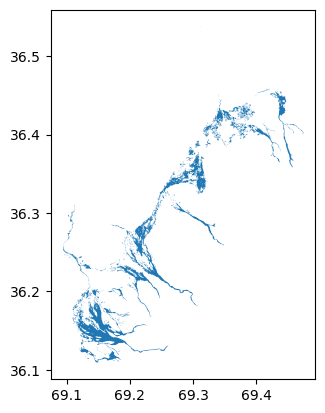

In [48]:
df_event_f.plot()

In [49]:
EXTERNAL_VAL_DATA_DIR = Path('../external_validation_data_db/')
EXTERNAL_VAL_DATA_DIR.mkdir(exist_ok=True, parents=True)

In [50]:
#df_event_f.to_parquet(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.parquet')

In [51]:
df_event_f.to_file(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')

# Extent

In [52]:
dfs2 = [gpd.read_file(p) for p in aoi_shps]
df_aoi = pd.concat(dfs2, axis=0)
df_aoi = df_aoi.to_crs(4326)
df_aoi.head()

,SensorDate,SensorID,Notes,Area_m2,GlobalID,StaffID,EventCode,Area_ha,SHAPE_Leng,SHAPE_Area,d_SensorID,d_StaffID,geometry
0,2024-05-15,44,None,1.072363e+09,{F0097FE1-6512-4B1E-B7DD-4CD302AF6C50},219,FL20240512AFG,107236.0,1.4034,0.107598,Sentinel-2,SS,"POLYGON ((69.20971 36.07001, 69.00519 36.18557..."


<Axes: >

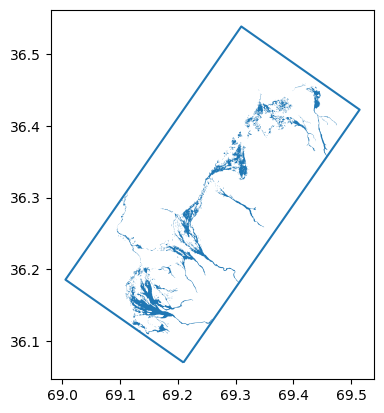

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df_aoi.boundary.plot(ax=ax)
df_event.plot(ax=ax)

In [54]:
EXTERNAL_VAL_EXTENTS = Path('../external_validation_data_extents_db/')
EXTERNAL_VAL_EXTENTS.mkdir(exist_ok=True, parents=True)

df_aoi.to_file(EXTERNAL_VAL_EXTENTS / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')